In [1]:
import pandas as pd
import numpy as np
from io import StringIO
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve, fit_and_score_pipeline, exp_range, \
    validation_curve_with_undersampling, plot_validation_curve_with_undersampling, fit_and_score_iteratively
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import fbeta_score, make_scorer

In [2]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [3]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0


# data = data[~np.isnan(data).any(axis=1)]
print(data[:,-1])

print(f'data.shape={data.shape}')

X, y = data[:,:-1], data[:, -1]
# X, y, idx = balanced_sampling(X, y, r = 3, random_state=42)

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y.astype(str))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print(f'X.shape={X.shape}, y.shape={y.shape}')

[0. 0. 0. ... 1. 1. 1.]
data.shape=(43405, 65)
X.shape=(43405, 64), y.shape=(43405,)


# Try naive fit

In [7]:
# no undersampling
# Baseline model

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

classifier = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=30, random_state=0, max_iter=1000)
res = fit_and_score_iteratively(classifier, X, y, None, 10)


In [8]:
print(res)

[0.94278913 0.04118404 0.10666667 0.02551834 0.50735377]


In [9]:
# Undersampling to a 3:1 ratio
# Baseline model
classifier = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=30, random_state=0, max_iter=1000)
res = fit_and_score_iteratively(classifier, X, y, 3, 10)


a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683
a=0.10662111516202229, r=3, gamma=19.758010521281683


In [10]:
print(res)

[0.66042248 0.35618747 0.36559198 0.37320574 0.56465813]


In [6]:
# Undersampling to a 1:1 ratio
# Baseline model
classifier = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=30, random_state=0, max_iter=1000)
res = fit_and_score_iteratively(classifier, X, y, 1, 10)


a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683


In [7]:
print(res)

[0.57482072 0.56942881 0.58846807 0.5784689  0.57482362]


In [9]:
# normalizing data with pipeline 

classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-4, 
                           hidden_layer_sizes=30, random_state=0, max_iter=2000)
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.7438247  0.74532983 0.74090471 0.75007974 0.74382968]


# Tuning Hyperparameters

In [ ]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

### hidden_layer_sizes

<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<clas

/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0,

/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0,

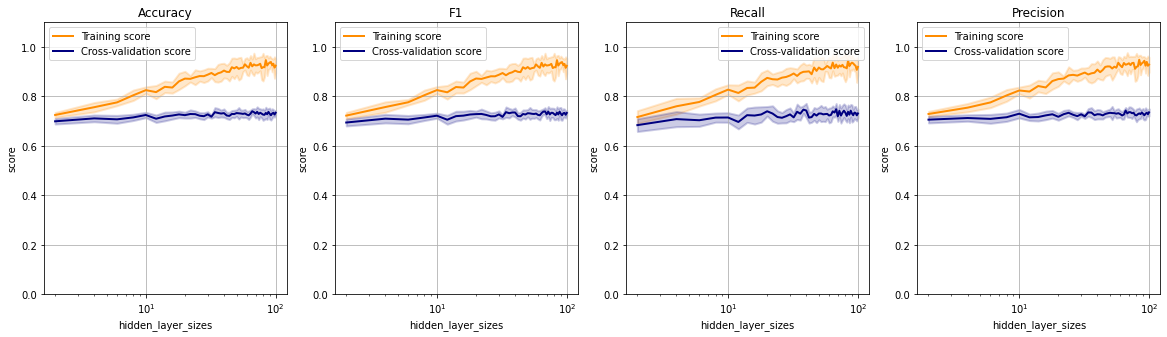

In [10]:
# optimize hidden_layer_sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = range(2, 101, 2)
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-4, random_state=0, max_iter=2000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='hidden_layer_sizes', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, is_pipe=True, 
                                                              x_axis_is_log=True)


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0,

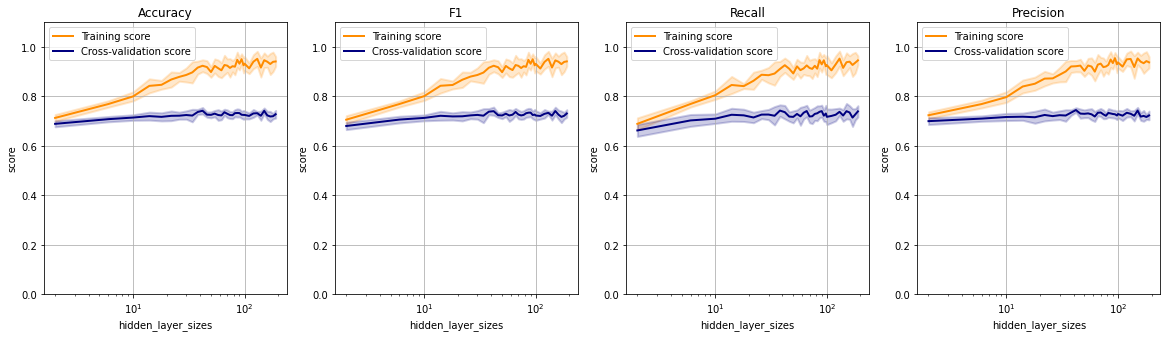

In [11]:
# optimize hidden_layer_sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = list(range(2, 100, 4)) + list(range(100, 200, 10))
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-4, random_state=0, max_iter=3000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='hidden_layer_sizes', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, is_pipe=True, 
                                                              x_axis_is_log=True)


In [12]:
results_store

{'fit_time': array([[  2.        ,   1.22891343,   0.25043514],
        [  6.        ,   3.08294787,   0.66600306],
        [ 10.        ,   5.8997761 ,   1.0109449 ],
        [ 14.        ,   8.30425966,   1.95623437],
        [ 18.        ,   7.48260176,   1.21349347],
        [ 22.        ,   7.87944758,   1.65178883],
        [ 26.        ,   7.23668962,   1.94502142],
        [ 30.        ,   7.822807  ,   1.6101497 ],
        [ 34.        ,   8.03279555,   1.73015271],
        [ 38.        ,   9.70688071,   1.04461866],
        [ 42.        ,   9.63787663,   1.07987466],
        [ 46.        ,   8.62356064,   1.89436637],
        [ 50.        ,   7.7243813 ,   2.02966253],
        [ 54.        ,   8.75873835,   2.21305599],
        [ 58.        ,   8.57100062,   1.99850629],
        [ 62.        ,   8.13221326,   1.59196835],
        [ 66.        ,   8.38292711,   1.42467948],
        [ 70.        ,   8.79077508,   2.15165885],
        [ 74.        ,  10.17212982,   2.16083682],


In [17]:
# use 42 as hidden layer size

classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-4, 
                           hidden_layer_sizes=42, random_state=0, max_iter=2000)
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.75211155 0.75381768 0.7478144  0.76028708 0.75211806]


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


/home/jay/gatech/cs7641/supervised_learning/helpers.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scoring


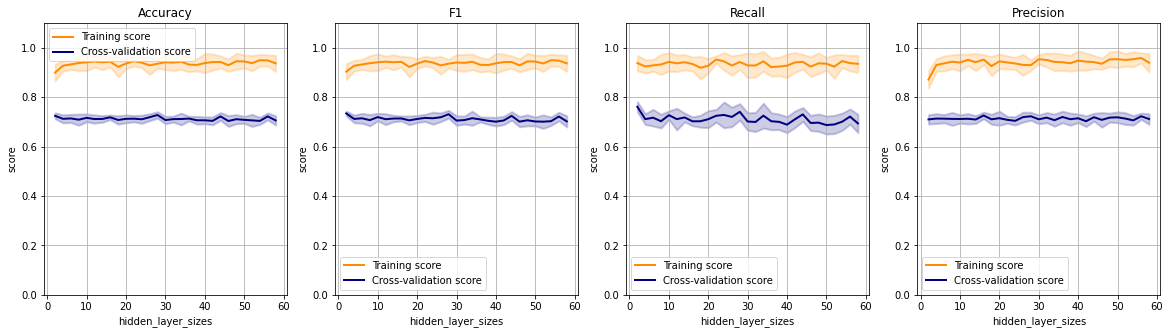

In [13]:
# optimize hidden_layer_sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# param_range = range(1, 3)
# param_range = list(range(1, 71, 2)) + list(range(70, 210, 10)) + list(range(200, 500, 20)) + list(range(500, 1000, 50))
param_range = list(range(2, 60, 2)) # + list(range(70, 210, 10)) + list(range(200, 500, 20)) + list(range(500, 1000, 50))
param_range = [(42, p) for p in param_range]
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-4, random_state=0, max_iter=3000)

results_store_2, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='hidden_layer_sizes', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, is_pipe=True, 
                                                              x_axis_is_log=False, param_range_idx=1)




# Learning rate

param=0.0001
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0001
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0002
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0003
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0004
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0005
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0006
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0007
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0008
<cl

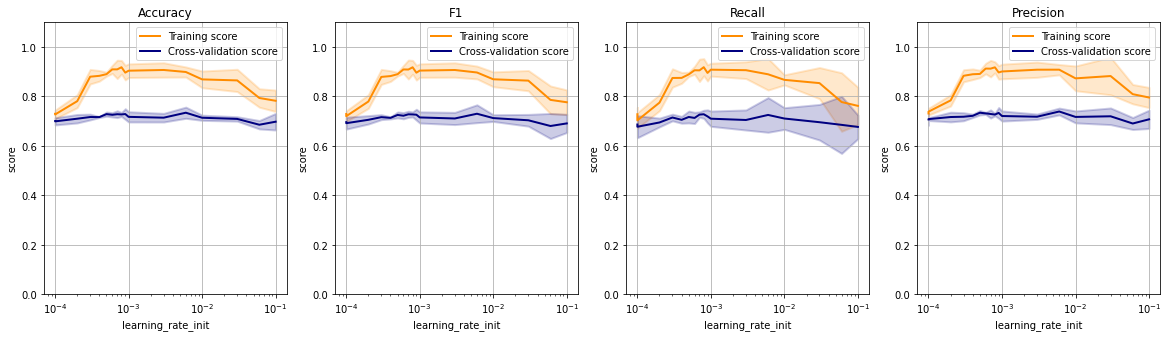

In [20]:
# optimize using learning rate
# set update scheme to "adaptive" instead of default "constant"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = [1e-4, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 3e-3, 6e-3, 1e-2, 3e-2, 6e-2, 1e-1]
param_range.sort()
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=42,
                           alpha=1e-4, random_state=0, max_iter=5000, learning_rate='adaptive')

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='learning_rate_init', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=2, undersampling_ratio=1, is_pipe=True, 
                                                              x_axis_is_log=True, param_range_idx=1)




In [21]:
results_store

{'fit_time': array([[1.00000000e-04, 3.05005646e+00, 1.05014463e+00],
        [1.00000000e-04, 3.48195678e+00, 8.81437161e-01],
        [2.00000000e-04, 6.23355120e+00, 2.32228971e+00],
        [3.00000000e-04, 1.51635103e+01, 2.00481827e+00],
        [4.00000000e-04, 1.36285166e+01, 9.39702596e-01],
        [5.00000000e-04, 1.28662412e+01, 1.45947682e+00],
        [6.00000000e-04, 1.24179075e+01, 1.85392310e+00],
        [7.00000000e-04, 1.10428805e+01, 3.66648155e+00],
        [8.00000000e-04, 1.07800628e+01, 3.22208886e-01],
        [9.00000000e-04, 1.00020038e+01, 6.61136382e-01],
        [1.00000000e-03, 8.83641791e+00, 1.29750982e+00],
        [3.00000000e-03, 3.69131994e+00, 2.24044029e-01],
        [6.00000000e-03, 1.17225307e+00, 1.55255662e-01],
        [1.00000000e-02, 1.22408915e+00, 5.60735599e-01],
        [3.00000000e-02, 4.85872090e-01, 7.12981228e-02],
        [6.00000000e-02, 3.46823514e-01, 1.52654744e-01],
        [1.00000000e-01, 6.33711219e-01, 2.65592560e-01]]),


param=0.0001
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0001
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0002
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0003
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0004
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0005
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0006
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0007
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=0.0008
<cl

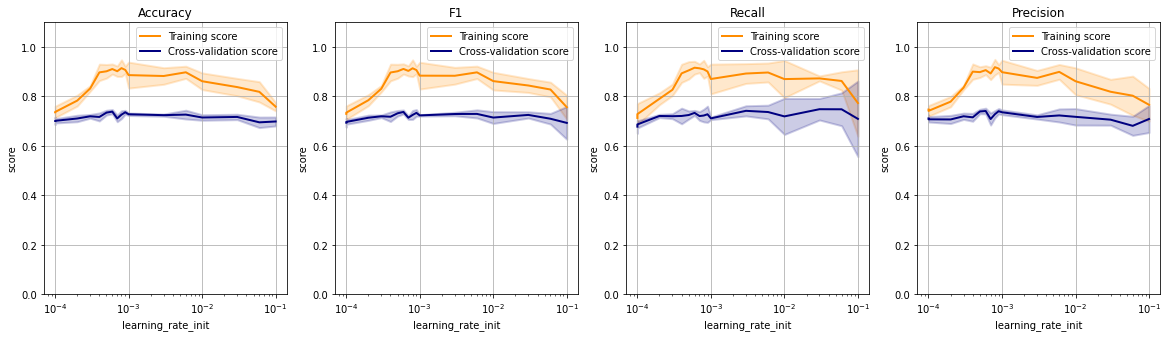

In [22]:
# optimize using learning rate
# set update scheme to "adaptive" instead of default "constant"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = [1e-4, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 3e-3, 6e-3, 1e-2, 3e-2, 6e-2, 1e-1]
param_range.sort()
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=42,
                           alpha=1e-4, random_state=0, max_iter=5000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='learning_rate_init', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=2, undersampling_ratio=1, is_pipe=True, 
                                                              x_axis_is_log=True, param_range_idx=1)




### regularization alpha

<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0,

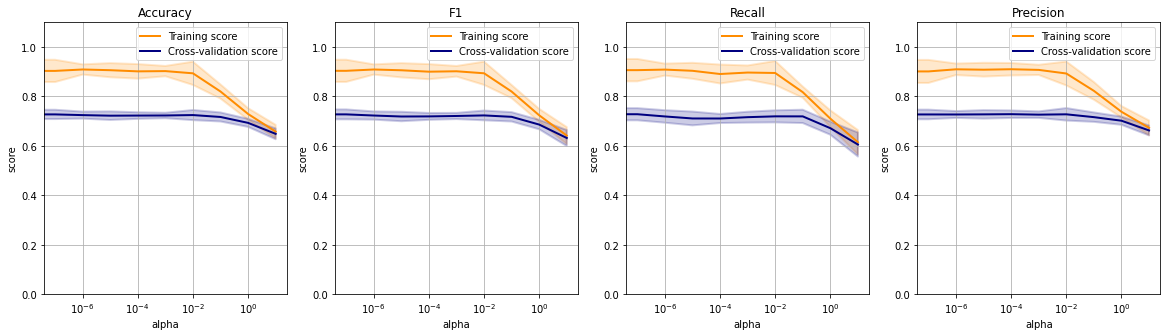

In [21]:
# optimize alpha
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=42, random_state=0, max_iter=3000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='alpha', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, is_pipe=True, 
                                                              x_axis_is_log=True)


In [22]:
results_store

{'fit_time': array([[0.00000000e+00, 7.66132884e+00, 2.40928760e+00],
        [1.00000000e-07, 7.08878436e+00, 1.48911549e+00],
        [1.00000000e-06, 7.27631872e+00, 1.51477217e+00],
        [1.00000000e-05, 6.25940940e+00, 1.22946408e+00],
        [1.00000000e-04, 6.39659772e+00, 1.09297721e+00],
        [1.00000000e-03, 7.52501016e+00, 1.07548941e+00],
        [1.00000000e-02, 5.77349684e+00, 1.70330248e+00],
        [1.00000000e-01, 3.35305996e+00, 5.58529218e-01],
        [1.00000000e+00, 9.83091640e-01, 3.10786974e-01],
        [1.00000000e+01, 5.44116378e-01, 3.22571192e-01]]),
 'score_time': array([[0.00000000e+00, 5.30278683e-03, 1.40493385e-04],
        [1.00000000e-07, 6.86678886e-03, 5.08413440e-03],
        [1.00000000e-06, 6.82625771e-03, 5.00269064e-03],
        [1.00000000e-05, 5.11548519e-03, 2.32776997e-04],
        [1.00000000e-04, 5.29901981e-03, 3.98269613e-04],
        [1.00000000e-03, 1.37440205e-02, 8.49342846e-03],
        [1.00000000e-02, 5.27613163e-03, 3.1

param=identity
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=logistic
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


a=0.0, r=1, gamma=20.040858725761773


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


param=tanh
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
param=relu
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773
a=0.0, r=1, gamma=20.040858725761773


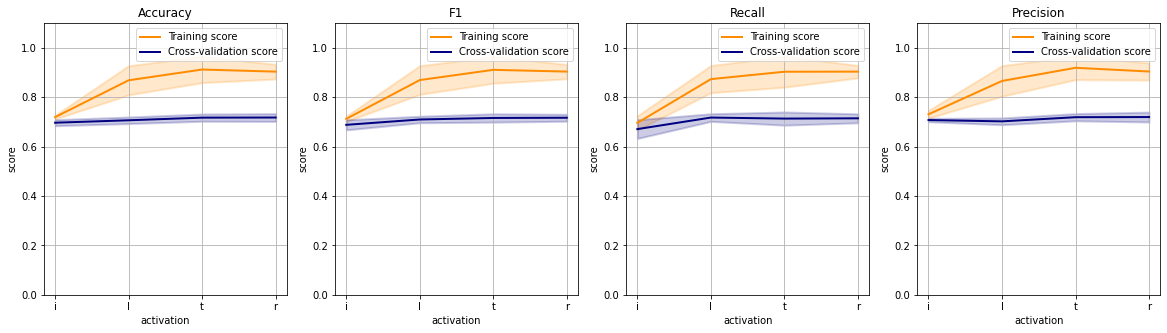

In [9]:
# Try different activation functions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

title = 'Activation Function'
param_range = ['identity', 'logistic', 'tanh', 'relu']

# optimize alpha

scoring = ['accuracy', 'f1', 'recall', 'precision']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=42, random_state=0, max_iter=3000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='activation', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=5, undersampling_ratio=1, is_pipe=True, 
                                                              x_axis_is_log=False)



In [11]:
results_store

{'fit_time': array([['identity', '0.9643794536590576', '0.625722487435513'],
        ['logistic', '13.545714855194092', '4.180422880829244'],
        ['tanh', '11.900203752517701', '3.476397648914954'],
        ['relu', '7.502553725242615', '1.5561320830001955']], dtype='<U18'),
 'score_time': array([['identity', '0.0052321434020996095', '0.0003262905736690418'],
        ['logistic', '0.011403870582580567', '0.008722243030163638'],
        ['tanh', '0.008485102653503418', '0.006238457389419405'],
        ['relu', '0.005316686630249023', '0.00017154964148415646']],
       dtype='<U22'),
 'test_accuracy': array([['identity', '0.6964681440443213', '0.01221685947891296'],
        ['logistic', '0.7063019390581717', '0.0133548820595493'],
        ['tanh', '0.71696675900277', '0.01458261964767853'],
        ['relu', '0.7174515235457063', '0.015776711564950866']],
       dtype='<U20'),
 'train_accuracy': array([['identity', '0.7190443213296399', '0.007761486645532566'],
        ['logistic', '0

# Performance

In [ ]:
# normalizing data with pipeline 

classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-4, 
                           hidden_layer_sizes=42, random_state=0, max_iter=2000)
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)

In [23]:
# use 42 as hidden layer size

classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-7, 
                           hidden_layer_sizes=42, random_state=0, max_iter=3000)
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.74573705 0.7447285  0.74704991 0.74290271 0.7457348 ]


In [16]:
# use 42 as hidden layer size

classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-7, 
                           hidden_layer_sizes=42, random_state=0, max_iter=3000, learning_rate="adaptive")
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.76334661 0.76144578 0.76699029 0.75598086 0.76334075]


In [17]:
# use 42 as hidden layer size

classifier = MLPClassifier(solver='adam', activation='relu', alpha=1e-7, 
                           hidden_layer_sizes=42, random_state=0, max_iter=3000, learning_rate="adaptive",
                          momentum=1)
pipe = make_pipeline(StandardScaler(), classifier)

res = fit_and_score_iteratively(pipe, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.76653386 0.77409406 0.74925373 0.80063796 0.76656102]


# Learning Curve

iteration 1
a=0.0, r=1, gamma=19.753415300546447


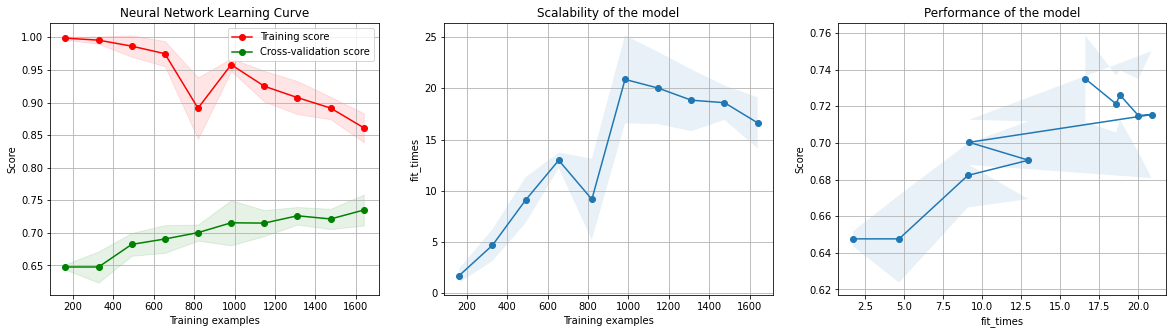

In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

classifier = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=42, random_state=42, max_iter=4000, 
                          momentum=1, learning_rate="adaptive")
pipe = make_pipeline(StandardScaler(), classifier)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

title = 'Neural Network Learning Curve'
result = plot_learning_curve(pipe, title, X_train, y_train, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy', iterations=1,
                            undersampling=True)


In [13]:
print(result)

{'train_sizes': array([ 163,  327,  491,  655,  819,  983, 1147, 1311, 1475, 1639]), 'train_scores_mean': array([0.99877301, 0.99571865, 0.98655804, 0.97496183, 0.89133089,
       0.95808749, 0.9250218 , 0.90755149, 0.89152542, 0.86125686]), 'train_scores_std': array([0.00245399, 0.00567194, 0.01637454, 0.01927779, 0.0470553 ,
       0.00955174, 0.02347824, 0.02532786, 0.01705998, 0.02225622]), 'test_scores_mean': array([0.64763433, 0.64764148, 0.68228875, 0.69058739, 0.70035303,
       0.71547498, 0.71498837, 0.72621743, 0.72133341, 0.73501222]), 'test_scores_std': array([0.00412748, 0.02385591, 0.01746206, 0.0212472 , 0.01231386,
       0.0346182 , 0.0198816 , 0.01347797, 0.01558249, 0.02369177]), 'fit_times_mean': array([ 1.71170139,  4.66456118,  9.07933927, 12.97238894,  9.16041636,
       20.8750195 , 20.02574739, 18.84236379, 18.5978569 , 16.62612777]), 'fit_times_std': array([0.68505295, 1.54790131, 2.23979552, 0.75301017, 3.97390663,
       4.29441322, 3.52369117, 3.02046523, 

iteration 1
a=0.0, r=1, gamma=19.753415300546447


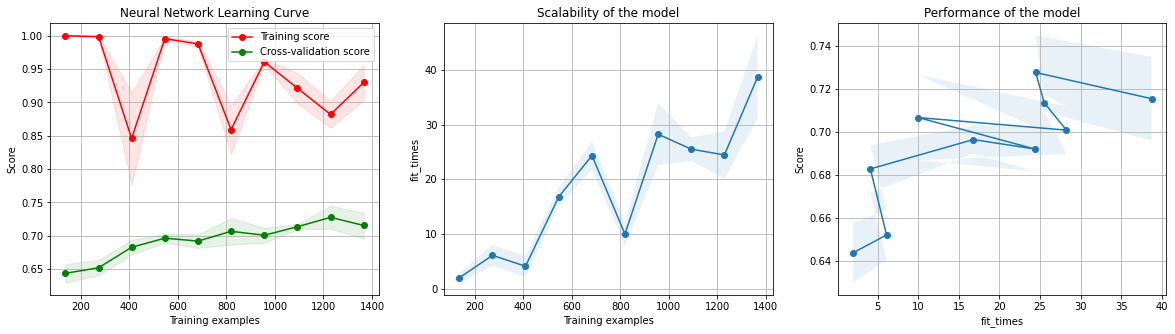

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

classifier = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=42, random_state=42, max_iter=4000, 
                          momentum=0.9, )
pipe = make_pipeline(StandardScaler(), classifier)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

title = 'Neural Network Learning Curve'
result = plot_learning_curve(pipe, title, X_train, y_train, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy', iterations=1,
                            undersampling=True)


In [5]:
print(result)

{'train_sizes': array([ 136,  273,  409,  546,  683,  819,  956, 1092, 1229, 1366]), 'train_scores_mean': array([1.        , 0.998779  , 0.84596577, 0.9957265 , 0.98779893,
       0.85917786, 0.9609484 , 0.92155067, 0.8820179 , 0.92996584]), 'train_scores_std': array([0.        , 0.00172676, 0.06926986, 0.00228428, 0.00452592,
       0.03641687, 0.00403621, 0.02269552, 0.02000811, 0.02654568]), 'test_scores_mean': array([0.64372865, 0.65202538, 0.68277208, 0.69643729, 0.6920449 ,
       0.70668619, 0.70082967, 0.71351879, 0.72767204, 0.71547096]), 'test_scores_std': array([0.01385561, 0.01161091, 0.01110767, 0.00658406, 0.01030684,
       0.0198724 , 0.01110767, 0.00384285, 0.01724111, 0.01943612]), 'fit_times_mean': array([ 1.96717827,  6.08655516,  4.09149543, 16.77744095, 24.3554012 ,
        9.98592416, 28.24937749, 25.52112683, 24.45663635, 38.73426803]), 'fit_times_std': array([0.85612835, 1.8960029 , 1.91529146, 1.76001571, 2.56577426,
       2.09297488, 5.68504113, 2.1281519 , 